# Class - RegistrationObj 

In [102]:
from utils import colour_map, min_max_normalisation, mae
from open3d import JVisualizer
from xlrd import XLRDError

import pandas as pd
import numpy as np
import open3d as o3d
import copy
import matplotlib.pyplot as plt
import tifffile.tifffile as tiff


class RegistrationObj():
    
    def __init__(self, pos_path_source, pos_path_target, color_path_source, color_path_target, 
                 algorithm = "colored_icp", **kwargs):
        self.pos_path_source= pos_path_source
        self.source_pcd = o3d.geometry.PointCloud()
        self.pos_path_target= pos_path_target
        self.target_pcd = o3d.geometry.PointCloud()
        self.color_path_source= color_path_source
        self.source_color = None
        self.norm_source_color = None
        self.color_path_target= color_path_target
        self.target_color = None
        self.norm_target_color = None
        self.algorithm = algorithm 
        self.preprocessing = False
        self.result = None
        self.registration_result = o3d.pipelines.registration.RegistrationResult()
        self.mae = None
        self.registered_color = None
        self.registered_target = None
        self.method = "Median"
        
        """Setting the arguments for create_pcd"""
        self.pos_skiprows = None
        self.pos_usecols = None
        self.pos_header = 0
        self.color_skiprows = None
        self.color_usecols = None
        self.color_header = 0
        
        self.__dict__.update(kwargs)

        """ Setting the values of registration parameters"""
        self.voxel_size =  kwargs.get('voxel_size', 10)
        self.downsampling =  kwargs.get('downsampling', False)
        self.norm_radius_modifier = kwargs.get('norm_radius_modifier', 2)
        self.norm_maxnn = kwargs.get('norm_maxnn', 30)
        self.fpfh_radius_modifier = kwargs.get('fpfh_radius_modifier', 5)
        self.fpfh_maxnn = kwargs.get('fpfh_maxnn', 100)
        self.ransac_dist_modifier = kwargs.get('ransac_dist_modifier', 1.5)
        self.ransac_edge_length = kwargs.get('ransac_edge_length', 0.9)
        self.ransac_mutual_filter = kwargs.get('ransac_edge_length', True)
        self.icp_dist_check = kwargs.get('icp_dist_check', 1)
        self.coloredICP_maxnn = kwargs.get('coloredICP_maxnn', 50)
        
        
    def __str__(self):
        try:
            string = """--- Registration Object--- \nAlgorithm used = {0} \nPreprocessing performed = {1} \nRegistration performed = {2} 
            \nFitness = {3:.2f} \nInlier RMSE = {4:.2f} \nScaled inlier RMSE = {5:.2f} \nMAE = {6:.2f} 
            \nRegistered color = {7}""". format(self.algorithm, self.preprocessing, 
                                                          self.result, 
                                                         self.registration_result.fitness,
                                                         self.registration_result.inlier_rmse, 
                                                          (self.registration_result.inlier_rmse/self.registration_result.fitness),
                                                         self.mae, self.registered_color)
            return string
        
        except ZeroDivisionError:
            """ Occurs if registration hasn't been performed as scaled_inlier_rmse divides by zero fitness"""
            
            string = """--- Registration Object--- \nAlgorithm used = {0} \nPreprocessing performed = {1} \nRegistration performed = {2}""" .format(self.algorithm, self.preprocessing, self.result) 
        return string
    
    def __repr__(self):
        return self.__str__()

    def preprocessing_status_update(self):
        self.preprocessing = True
        
    def result_status_update(self):
        self.result = True
                 
    def registration_result_update(self, registration_result):
        self.registration_result = registration_result
        
    def update_source_color(self, source_color):
        self.source_color = source_color
    
    def update_norm_source_color(self, norm_source_color):
        self.norm_source_color = norm_source_color
    
    def update_target_color(self, target_color):
        self.target_color = target_color
    
    def update_norm_target_color(self, norm_target_color):
        self.norm_target_color = norm_target_color
        
    def update_source_pcd(self, source_pcd):
        self.source_pcd = source_pcd
        
    def update_target_pcd(self, target_pcd):
        self.target_pcd = target_pcd
    
    def update_mae(self, mae):
        self.mae = mae
    
    def update_registered_color(self, registered_color):
        self.registered_color = registered_color
    
    def update_registered_target(self, registered_target):
        self.registered_target = registered_target  

    def create_pcd(self, print_filenames = False):
        """ Converts excel (.xls or .csv) files containing xyz coordinates into geometry.PointCloud object. 
        Returns the filenames as a list if return_filenames=True. """

        filenames = []
        
        """ Handling .xls files"""
        try: 
            source_df = pd.read_excel(self.pos_path_source, skiprows = self.pos_skiprows, usecols = self.pos_usecols, header = self.pos_header)
            target_df = pd.read_excel(self.pos_path_target, skiprows = self.pos_skiprows, usecols = self.pos_usecols, header = self.pos_header)
            source_color_df = pd.read_excel(self.color_path_source, skiprows = self.color_skiprows, usecols = self.color_usecols, header = self.color_header)
            target_color_df = pd.read_excel(self.color_path_target, skiprows = self.color_skiprows, usecols = self.color_usecols, header = self.color_header)
            
            source_pcd = o3d.geometry.PointCloud() 
            source_np = np.asarray(source_df)
            source_color = np.asarray(source_color_df)
            norm_colors_source = min_max_normalisation(source_color)
            self.update_source_color(source_color)
            self.update_norm_source_color(norm_colors_source)
            source_rgb, _ = colour_map(source_color,"viridis")
            source_pcd.points=o3d.utility.Vector3dVector(source_np)
            source_pcd.colors=o3d.utility.Vector3dVector(source_rgb)
            o3d.io.write_point_cloud(self.pos_path_source.split('.xls')[0] + '.pcd', source_pcd)
            self.update_source_pcd(source_pcd)
            filenames.append(self.pos_path_source.split('.xls')[0] + '.pcd')
            
            target_pcd = o3d.geometry.PointCloud() 
            target_np = np.asarray(target_df)
            target_color = np.asarray(target_color_df)
            norm_colors_target = min_max_normalisation(target_color)
            self.update_target_color(target_color)
            self.update_norm_target_color(norm_colors_target)
            target_rgb, _ = colour_map(target_color,"viridis")
            target_pcd.points=o3d.utility.Vector3dVector(target_np)
            target_pcd.colors=o3d.utility.Vector3dVector(target_rgb)
            o3d.io.write_point_cloud(self.pos_path_target.split('.xls')[0] + '.pcd', target_pcd)
            self.update_target_pcd(target_pcd)
            filenames.append(self.pos_path_target.split('.xls')[0] + '.pcd')
            
            return source_pcd, target_pcd

        except XLRDError:
     
            """ Handling .csv files"""
            try:
                source_df = pd.read_csv(self.pos_path_source, skiprows = self.pos_skiprows, usecols = self.pos_usecols, header = self.pos_header)
                target_df = pd.read_csv(self.pos_path_target, skiprows = self.pos_skiprows, usecols = self.pos_usecols, header = self.pos_header)
                source_color_df = pd.read_csv(self.color_path_source, skiprows = self.color_skiprows, usecols = self.color_usecols, header = self.color_header)
                target_color_df = pd.read_csv(self.color_path_target, skiprows = self.color_skiprows, usecols = self.color_usecols, header = self.color_header)


                source_pcd = o3d.geometry.PointCloud() 
                source_np = np.asarray(source_df)
                source_color = np.asarray(source_color_df)
                norm_colors_source = min_max_normalisation(source_color)
                self.update_source_color(source_color)
                self.update_norm_source_color(norm_colors_source)
                source_rgb, _ = colour_map(source_color,"viridis")
                source_pcd.points=o3d.utility.Vector3dVector(source_np)
                source_pcd.colors=o3d.utility.Vector3dVector(source_rgb)
                o3d.io.write_point_cloud(self.pos_path_source.split('csv')[0] + '.pcd', source_pcd)
                self.update_source_pcd(source_pcd)
                filenames.append(self.pos_path_source.split('.csv')[0] + '.pcd')

                target_pcd = o3d.geometry.PointCloud() 
                target_np = np.asarray(target_df)
                target_color = np.asarray(target_color_df)
                norm_colors_target = min_max_normalisation(target_color)
                self.update_target_color(target_color)
                self.update_norm_target_color(norm_colors_target)
                target_rgb, _ = colour_map(target_color,"viridis")
                target_pcd.points=o3d.utility.Vector3dVector(target_np)
                target_pcd.colors=o3d.utility.Vector3dVector(target_rgb)
                o3d.io.write_point_cloud(self.pos_path_target.split('.csv')[0] + '.pcd', target_pcd)
                self.update_target_pcd(target_pcd)
                filenames.append(self.pos_path_target.split('.csv')[0] + '.pcd')
            
                return source_pcd, target_pcd

            except ValueError as v:
                
                print("Input excel files are not of extension .xls or .csv. Please convert both files to either one of these formats.")
                print(v)
                
        finally:
            if print_filenames:
                print (filenames)
  
        
    def preprocessing_func(self, verbose = True):
            
        """ Down sample the point cloud, estimate normals, then compute a FPFH feature for each point. 
        Returns the processed PointCloud object and an open3d.registration.Feature class object."""

        source_pcd, target_pcd = self.create_pcd()   

        if self.downsampling:
            source_processed = source_pcd.voxel_down_sample(self.voxel_size)
            target_processed = target_pcd.voxel_down_sample(self.voxel_size)

            if verbose:
                print(f":: Downsample with a voxel size {voxel_size}")
        else:
            source_processed = source_pcd
            target_processed = target_pcd

            if verbose:
                print(":: Point Cloud was not downsampled")

        radius_normal = self.voxel_size * self.norm_radius_modifier
        radius_feature = self.voxel_size * self.fpfh_radius_modifier

        if verbose:
            print(f":: Estimate normal with search radius {radius_normal}.")
            print(f":: Compute FPFH feature with search radius {radius_feature}.\n---------------------------------------")

        source_processed.estimate_normals(
            search_param = 
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=self.norm_maxnn),
        fast_normal_computation = True)

        source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            source_processed,
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=self.fpfh_maxnn))

        target_processed.estimate_normals(
            search_param = 
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=self.norm_maxnn),
        fast_normal_computation = True)

        target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            target_processed,
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=self.fpfh_maxnn))
        
        self.preprocessing_status_update()
        
        return source_processed, target_processed, source_fpfh, target_fpfh
    
    def global_ransac_registration(self, verbose = True):
        """ Implements the RANSAC registration based on feature matching and returns a registration.RegistrationResult object.

        Source: Adapted from open3d global registration documentation: http://www.open3d.org/docs/release/tutorial/pipelines/global_registration.html

        Parameters:
        ----------
        source_processed: geometry.PointCloud
            Source point cloud after downsampling (if downsample=True) and normal estimation
        target_processed: geometry.PointCloud
            Target point cloud after downsampling (if downsample=True) and normal estimation
        source_fpfh: registration.Feature
            Source point cloud fpfh information
        target_fpfh: registration.Feature
            Target point cloud fpfh information
        voxel_size: float, optional
            Multiplied with the ransac_dist_modifier to yield the distance threshold used by CorrespondenceCheckerBasedOnDistance
        ransac_dist_modifier:float, optional
            Multiplied with the voxel_size to yield the distance threshold used by CorrespondenceCheckerBasedOnDistance
        ransac_edge_length: float, optional
            Input to CorrespondenceCheckerBasedOnEdgeLength

        Return:
        ----------
        result: registration.RegistrationResult
            Result of RANSAC alignment
        """

        distance_threshold = self.voxel_size * self.ransac_dist_modifier

        if verbose:
            print(":: RANSAC registration on point clouds.")
            print("   Since the  voxel size is %.3f," % self.voxel_size)
            print("   we use a liberal distance threshold %.3f." % distance_threshold)
            
        source_processed, target_processed, source_fpfh, target_fpfh = self.preprocessing_func(verbose = verbose)

        result_ransac = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source_processed, target_processed, source_fpfh, target_fpfh, self.ransac_mutual_filter, distance_threshold,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 4, [
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(self.ransac_edge_length),
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                    distance_threshold)
            ], o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))
        
        self.registration_result_update(result_ransac)
        self.result_status_update()
        self.calculate_mae()
        
        return result_ransac
    
    def icp_registration(self, verbose = True):  
        """ Implements the Point-to-Plane ICP registration algorithm and returns a registration.RegistrationResult object.
        """

        ransac_transform = self.global_ransac_registration(verbose = verbose)
        
        source_processed, target_processed, source_fpfh, target_fpfh = self.preprocessing_func(verbose = verbose)

        distance_threshold = self.voxel_size * self.icp_dist_check

        result_icp = o3d.pipelines.registration.registration_icp(
            source_processed, target_processed, distance_threshold, ransac_transform.transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPlane(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration = 2000))
                        

        self.registration_result_update(result_icp)
        self.result_status_update()
        self.calculate_mae()
        
        return result_icp


    def colored_icp(self, verbose = True):
        """ Implements the Colored ICP registration algorithm and returns a registration.RegistrationResult object.

        Source: Adapted from open3d ICP registration documentation:http://www.open3d.org/docs/release/tutorial/pipelines/colored_pointcloud_registration.html
        """
        
        ransac_transform = self.global_ransac_registration(verbose = verbose)
        
        source_processed, target_processed, source_fpfh, target_fpfh = self.preprocessing_func(verbose = verbose)

        current_transformation = ransac_transform.transformation

        source_colorreg = copy.deepcopy(source_processed)
        target_colorreg = copy.deepcopy(target_processed)

        if self.downsampling:
            source_colorreg = source_colorreg.voxel_down_sample(self.voxel_size)
            target_colorreg = target_colorreg.voxel_down_sample(self.voxel_size)

        source_colorreg.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=self.voxel_size * 2, max_nn=self.coloredICP_maxnn))

        target_colorreg.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=self.voxel_size * 2, max_nn=self.coloredICP_maxnn))

        result_icp_colored = o3d.pipelines.registration.registration_colored_icp(
            source_colorreg, target_colorreg, self.voxel_size, current_transformation,
            o3d.pipelines.registration.TransformationEstimationForColoredICP(),
            o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                    relative_rmse=1e-6,
                                                    max_iteration=100))

        current_transformation = result_icp_colored.transformation
        
        self.registration_result_update(result_icp_colored)
        self.result_status_update()
        self.calculate_mae()

        return result_icp_colored
    
    def perform_registration(self, verbose = True):
        if self.algorithm == "ransac":
            return self.global_ransac_registration(verbose = verbose)
            
        elif self.algorithm == "icp":
            return self.icp_registration(verbose = verbose)

        elif self.algorithm == "colored_icp":
            return self.colored_icp(verbose = verbose)
        
        else:
            print("Only 'ransac', 'icp' and 'colored_icp' are available algorithms to choose from.")
            return None
        
    def calculate_mae(self):
        """Returns the mean absolute error between the source and target color intensity channels

        Parameters:
        ----------
        source_color: np.array
            Source color channel (raw) intensity values
        target_color: np.array
            Target color channel (raw) intensity values
        registration_result: registration.RegistrationResult
            Registration result of alignment

        Return:
        ---------
        mae: float
            Mean absolute error 
        """
        corr_result_ransac = np.array(self.registration_result.correspondence_set)
        source_indices_ransac = corr_result_ransac[:,0]
        target_indices_ransac = corr_result_ransac[:,1]
        source_color_norm = self.norm_source_color[source_indices_ransac]
        target_color_norm = self.norm_target_color[target_indices_ransac]
        
        self.update_mae(mae(source_color_norm, target_color_norm)[0])
    
    def obtain_registration_metrics(self):
        """ For a particular registration result, displays the fitness, inlier RMSE and MAE estimate. Also describes the correspondence 
        map properties. 

        Parameters:
        ----------
        target: geometry.PointCloud
            Target point cloud
        source_color: np.array
            Source color channel (raw) intensity values
        target_color: np.array
            Target color channel (raw) intensity values
        registration_result: registration.RegistrationResult
            Registration result of alignment
        """

        print("--- Registration results --- ")
        print(f"Fitness: {self.registration_result.fitness*100:.2f}%")
        print(f"Inlier RMSE: {self.registration_result.inlier_rmse:.2f}")
        print(f"MAE: {self.mae:.2f}\n---------------------------------------")    

        corr_map = np.array(self.registration_result.correspondence_set)
        source_indices = corr_map[:,0]
        target_indices = corr_map[:,1]

        num_target = np.array(self.target_pcd.points).shape[0]
        target_range = np.arange(0, num_target)

        unmapped_targets =np.where(np.invert(np.in1d(target_range, target_indices)))[0]
        target_repeats = {i:list(target_indices).count(i) for i in target_indices if list(target_indices).count(i) > 1}
        unique_target_indices = [x for x in target_indices if x not in target_repeats]

        print("--- Correspondence map properties --- ")
        print(f"{len(unmapped_targets)} ({(len(unmapped_targets)/ num_target)*100:.3f}%) unmapped targets.")
        print(f"{len(target_repeats)} ({(len(target_repeats)/ num_target)*100:.3f}%) targets that are mapped by multiple source points.")
        print(f"{len(unique_target_indices)} ({(len(unique_target_indices)/ num_target)*100:.3f}%) targets that are uniquely mapped by a single source point.")

        if len(unmapped_targets) + len(target_repeats) + len(unique_target_indices) == len(self.target_pcd.points):
            print(f"All {len(self.target_pcd.points)} target points are accounted for.")

    def map_source2target(self, verbose = False):
        """ Returns the registered target point cloud, where the color intensity values of multiply mapped target points are imputed by
        a chosen averaging method. Currently, unmapped points in the target cloud retain their original intensities.

        Parameters:
        ----------
        source: geometry.PointCloud
            Source point cloud
        target: geometry.PointCloud
            Target point cloud
        source_color: np.array
            Source color channel intensity values
        target_color: np.array
            Target color channel intensity values
        registration_result: registration.RegistrationResult
            Registration result of alignment
        method: str
            A choice between "mean" or "median" averaging for imputing the intensity of multiply mapped target points
        verbose: boolean
            Prints the color numpy arrays before and after the mapping is performed.

        Return:
        --------
        target_new: geometry.PointCloud
            Updated target point cloud
        mapped_col_range: matplotlib.cm.ScalarMappable object 
        color_list: np.array
            Updated color intensity array of the target

        """
        corr_map = np.array(self.registration_result.correspondence_set)
        source_indices = corr_map[:,0]
        target_indices = corr_map[:,1]

        target_new = copy.deepcopy(self.target_pcd)
        color_list = copy.deepcopy(self.target_color)

        target_repeats = {i:list(target_indices).count(i) for i in target_indices if list(target_indices).count(i) > 1}
        unique_target_indices = [x for x in target_indices if x not in target_repeats]

        if self.method == "median" or self.method == "Median": 
            print("Using median averaging")
            for ind in target_repeats:
                bool_mask = target_indices == ind
                source_indices_repeat = source_indices[bool_mask]
                color_list[ind] = np.median(self.source_color[source_indices_repeat])

            for ind in unique_target_indices:
                bool_mask = target_indices == ind
                source_indices_unique = source_indices[bool_mask]
                color_list[ind] = self.source_color[source_indices_unique]

        elif self.method == "mean" or self.method == "Mean" or self.method == "average" or self.method == "Average":
            print("Using mean averaging")
            for ind in target_repeats:
                bool_mask = target_indices == ind
                source_indices_repeat = source_indices[bool_mask]
                color_list[ind] = np.mean(self.source_color[source_indices_repeat])

            for ind in unique_target_indices:
                bool_mask = target_indices == ind
                source_indices_unique = source_indices[bool_mask]
                color_list[ind] = self.source_color[source_indices_unique]
        else:
            raise Exception("Unrecognised method used. Only mean/average or median functions are permitted.") 

        if verbose:
            print("before assignment", np.array(target_new.colors))

        mapped_rgb, mapped_col_range=colour_map(color_list,"viridis")

        target_new.colors =o3d.utility.Vector3dVector(mapped_rgb)
        
        self.update_registered_color(color_list)
        self.update_registered_target(target_new)

        if verbose:
            print("after assignment", np.array(target_new.colors))
            print(np.all([mapped_rgb, np.array(target_new.colors)]))

        return (target_new,mapped_col_range, color_list)
    
    def map_source2target_null(self, method = "median", verbose = False):
        """ Returns the registered target point cloud, where the color intensity values of multiply mapped target points are imputed by
        a chosen averaging method. In contrast to map_source2target_null, unmapped points in the target have 0 intensity.

        Parameters:
        ----------
        source: geometry.PointCloud
            Source point cloud
        target: geometry.PointCloud
            Target point cloud
        source_color: np.array
            Source color channel intensity values
        target_color: np.array
            Target color channel intensity values
        registration_result: registration.RegistrationResult
            Registration result of alignment
        method: str
            A choice between "mean" or "median" averaging for imputing the intensity of multiply mapped target points
        verbose: boolean
            Prints the color numpy arrays before and after the mapping is performed.

        Return:
        --------
        target_new: geometry.PointCloud
            Updated target point cloud
        mapped_col_range: matplotlib.cm.ScalarMappable object 
        color_list: np.array
            Updated color intensity array of the target

        """
        corr_map = np.array(self.registration_result.correspondence_set)
        source_indices = corr_map[:,0]
        target_indices = corr_map[:,1]

        target_new = copy.deepcopy(self.target_pcd)
        color_list = np.zeros(shape=(self.target_color.shape))

        target_repeats = {i:list(target_indices).count(i) for i in target_indices if list(target_indices).count(i) > 1}
        unique_target_indices = [x for x in target_indices if x not in target_repeats]

        if method == "median" or method == "Median": 
            print("Using median averaging")
            for ind in target_repeats:
                bool_mask = target_indices == ind
                source_indices_repeat = source_indices[bool_mask]
                color_list[ind] = np.median(self.source_color[source_indices_repeat])

            for ind in unique_target_indices:
                bool_mask = target_indices == ind
                source_indices_unique = source_indices[bool_mask]
                color_list[ind] = self.source_color[source_indices_unique]

        elif method == "mean" or method == "Mean" or method == "average" or method == "Average":
            print("Using mean averaging")
            for ind in target_repeats:
                bool_mask = target_indices == ind
                source_indices_repeat = source_indices[bool_mask]
                color_list[ind] = np.mean(self.source_color[source_indices_repeat])

            for ind in unique_target_indices:
                bool_mask = target_indices == ind
                source_indices_unique = source_indices[bool_mask]
                color_list[ind] = self.source_color[source_indices_unique]
        else:
            raise Exception("Unrecognised method used. Only mean/average or median functions are permitted.") 

        if verbose:
            print("before assignment", np.array(target_new.colors))

        mapped_rgb, mapped_col_range=colour_map(color_list,"viridis")

        target_new.colors =o3d.utility.Vector3dVector(mapped_rgb)
        
        self.update_registered_color(color_list)
        self.update_registered_target(target_new)

        if verbose:
            print("after assignment", np.array(target_new.colors))
            print(np.all([mapped_rgb, np.array(target_new.colors)]))

        return (target_new,mapped_col_range, color_list)
    
    def transform_source(self):
        transformation = self.registration_result.transformation
        source_transformed= copy.deepcopy(self.source_pcd)
        source_transformed.transform(transformation)
        return source_transformed

    def pcd_to_tiff(pcd, intensity_array, xdim_px, ydim_px, zdim_px, x_res, y_res, z_res, spot_diameter, image_name):
    
        """ Takes each point of a point cloud and creates spots of a given pixel intensity given by intensity array. This is then exported as a tiff file. 
        Parameters:
        -----------
        point_cloud: open3d.geometry.PointCloud()
            The point_cloud to be exported as tiff file
        intensity_array: numpy.array()
        xdim_px: integer
            X-dimension of the output image in pixels
        ydim_px: integer
            Y-dimension of the output image in pixels
        zdim_px: integer
            Z-dimension of the output image in pixels
        x_res: float
            Number of microns per pixel in the X-dimension of the image
        y_res: float
            Number of microns per pixel in the Y-dimension of the image
        z_res: float
            Number of microns per pixel in the Z-dimension of the image
        spot_diameter: float
            Diameter in microns of spots representing each xyz-point in image
        image_name: string
            Name of output image

        Returns:
        --------
        None
        """
        export_pcd=np.asarray(pcd.points)
        export_image=np.zeros([zdim_px,xdim_px,ydim_px])

        export_x_location=np.round((export_pcd[:,0]-np.min(export_pcd[:,0]))*x_res).astype('int')
        export_y_location=np.round((export_pcd[:,1]-np.min(export_pcd[:,1]))*y_res).astype('int')
        export_z_location=np.round((export_pcd[:,2]-np.min(export_pcd[:,2]))*z_res).astype('int')

        pixel_radius=int(np.round(x_res*(spot_diameter/2)))

        for i in range(len(export_pcd)):
            print(len(export_pcd)-i,'remaining')
            center_point=export_x_location[i],export_y_location[i],export_z_location[i]
            for x in range(center_point[0]-pixel_radius,center_point[0]+pixel_radius+1):
                for y in range(center_point[1]-pixel_radius, center_point[1]+pixel_radius+1):
                    for z in range(center_point[2]-pixel_radius,center_point[2]+pixel_radius+1):
                        length=np.sqrt((x-center_point[0])**2+(y-center_point[1])**2+(z-center_point[2])**2)

                    if length<=int(np.round(pixel_radius)):
                        export_image[z,x,y]=intensity_array[i]

        tiff.imwrite(image_name,export_image.astype("uint8"), compression='jpeg')
        print('Saved',image_name,'as Tiff')

        return None



# Class - RegistrationObj-noisy

In [120]:
class RegistrationObj_noisy(RegistrationObj):
    
    def __init__(self, pos_path_source, pos_path_target, color_path_source, color_path_target, 
                 algorithm = "colored_icp",**kwargs):
        super().__init__(pos_path_source, pos_path_target, color_path_source, color_path_target, **kwargs)
        self.noisy_registrationObj = []
        self.noisy_pcd_list = []
        self.noisy_pcd_temp = o3d.geometry.PointCloud()
        
    def update_noisy_pcd_list(self, noisy_pcd_list):
        self.noisy_pcd_list = noisy_pcd_list
        
    def update_noisy_registrationObj(self, noisy_registrationObj):
        self.noisy_registrationObj = noisy_registrationObj
        
    def global_ransac_registration(self, verbose = True):

        distance_threshold = self.voxel_size * self.ransac_dist_modifier

        if verbose:
            print(":: RANSAC registration on point clouds.")
            print("   Since the  voxel size is %.3f," % self.voxel_size)
            print("   we use a liberal distance threshold %.3f." % distance_threshold)
            
        source_processed, target_processed, source_fpfh, target_fpfh = self.preprocessing_func(verbose = verbose)

        result_ransac = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            self.noisy_pcd_temp, target_processed, source_fpfh, target_fpfh, self.ransac_mutual_filter, distance_threshold,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 4, [
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(self.ransac_edge_length),
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                    distance_threshold)
            ], o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))

        self.registration_result_update(result_ransac)
        print(self.registration_result)
        self.result_status_update()

        return result_ransac

    def icp_registration(self, verbose = True):  
        """ Implements the Point-to-Plane ICP registration algorithm and returns a registration.RegistrationResult object.
        """

        ransac_transform = self.global_ransac_registration(verbose = verbose)
        
        source_processed, target_processed, source_fpfh, target_fpfh = self.preprocessing_func(verbose = verbose)

        distance_threshold = self.voxel_size * self.icp_dist_check

        result_icp = o3d.pipelines.registration.registration_icp(
            self.noisy_pcd_temp, target_processed, distance_threshold, ransac_transform.transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPlane(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration = 2000))
                        

        self.registration_result_update(result_icp)
        self.result_status_update()
        self.calculate_mae()
        
        return result_icp


    def colored_icp(self, verbose = True):
        """ Implements the Colored ICP registration algorithm and returns a registration.RegistrationResult object.

        Source: Adapted from open3d ICP registration documentation:http://www.open3d.org/docs/release/tutorial/pipelines/colored_pointcloud_registration.html
        """
        print("Entering into colored_ICP")
        ransac_transform = self.global_ransac_registration(verbose = verbose)
        
        source_processed, target_processed, source_fpfh, target_fpfh = self.preprocessing_func(verbose = verbose)

        current_transformation = ransac_transform.transformation

        source_colorreg = copy.deepcopy(self.noisy_pcd_temp)
        target_colorreg = copy.deepcopy(target_processed)

        if self.downsampling:
            source_colorreg = source_colorreg.voxel_down_sample(self.voxel_size)
            target_colorreg = target_colorreg.voxel_down_sample(self.voxel_size)

        source_colorreg.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=self.voxel_size * 2, max_nn=self.coloredICP_maxnn))

        target_colorreg.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=self.voxel_size * 2, max_nn=self.coloredICP_maxnn))

        result_icp_colored = o3d.pipelines.registration.registration_colored_icp(
            source_colorreg, target_colorreg, self.voxel_size, current_transformation,
            o3d.pipelines.registration.TransformationEstimationForColoredICP(),
            o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                    relative_rmse=1e-6,
                                                    max_iteration=100))

        current_transformation = result_icp_colored.transformation
        
        self.registration_result_update(result_icp_colored)
        self.result_status_update()
        self.calculate_mae()

        return result_icp_colored
        
    def simulate_noise(self, sd_range = 50, sd_interval = 3, sim_num = 2, ax = None, legend = True,
                  title = None, x_label = "Noise (standard deviation)", y_label = "Metric results",
                  results_only = False, verbose = False):
        
        self.create_pcd()

        """ Noise simulation"""
        noise_sd = np.linspace(0,sd_range,sd_interval)
        len_noise = len(noise_sd)
        size_data = np.asarray(self.source_pcd.points).shape

        noisy_pcd_list = []
        results_list = []
        noisy_registrationObj = []

        for j in range(sim_num):
            np.random.seed(j)
            print(f"----------Simulation num: {j+1}----------")
            for i in range(len_noise):
                source_pcd = copy.deepcopy(self.source_pcd)
                noise = np.random.normal(0,noise_sd[i],size_data)
                combined_noise = np.asarray(source_pcd.points) + noise
                self.noisy_pcd_temp.points=o3d.utility.Vector3dVector(np.asarray(combined_noise))
                
                noisy_pcd_temp = copy.deepcopy(self.noisy_pcd_temp)
                noisy_pcd_list.append(noisy_pcd_temp)
                myRegObj = self.perform_registration(verbose = verbose)
                MyRegObjCopy =copy.deepcopy(myRegObj)
                noisy_registrationObj.append(myRegObjCopy)

                results_list.append([self.registration_result.fitness, self.registration_result.inlier_rmse, 
                                     (self.registration_result.inlier_rmse)/(self.registration_result.fitness), 
                                     self.mae, (self.mae)/(self.registration_result.fitness), np.asarray(self.registration_result.correspondence_set).shape[0]])

        self.update_noisy_pcd_list(noisy_pcd_list)
        self.update_noisy_registrationObj(noisy_registrationObj)
        result_array = np.array(results_list)
        result = np.reshape(result_array, (sim_num,sd_interval,6))
        result_mean = np.mean(result, axis = 0)

        fitness = [mylist[0] for mylist in result_mean]
        inlier_rmse = [mylist[1] for mylist in result_mean]
        scaled_inlier_rmse = [mylist[2] for mylist in result_mean]
        mae = [mylist[3] for mylist in result_mean]
        scaled_inlier_mae = [mylist[4] for mylist in result_mean]
        corr_num = [mylist[5] for mylist in result_mean]


        if results_only:
            return np.asarray([fitness, inlier_rmse, scaled_inlier_rmse, mae, scaled_inlier_mae, corr_num])

        else:
            """ Plotting"""

            if ax is None:
                ax = plt.gca()
            ax.plot(noise_sd, fitness, label='Fitness')
            ax.plot(noise_sd, inlier_rmse, label='Inlier RMSE')
            ax.plot(noise_sd, mae, label='MAE')

            if legend:
                ax.legend(loc = "upper left")

            if title:
                ax.set_title(label = title)

            if x_label:
                ax.set_xlabel(x_label)

            if y_label:
                ax.set_ylabel(y_label)

            return ax


# Class - IterativePairwise

In [110]:
class IterativePairwise():
    
    def __init__(self, pos_path_source_list, pos_path_target, color_path_source_list, color_path_target, 
                 algorithm = "colored_icp", **kwargs):
        
        self.pos_path_source_list= pos_path_source_list
        self.pos_path_target = pos_path_target
        self.source_pcd = []
        self.target_pcd = None
        self.color_path_source_list = color_path_source_list
        self.color_path_target = color_path_target
        self.algorithm = algorithm
        self.source_length = len(self.pos_path_source_list)
        self.combined_results = []
        self.registered_color = None
        
                
        """Setting the arguments for RegistrationObj.create_pcd"""
        self.pos_skiprows = None
        self.pos_usecols = None
        self.pos_header = 0
        self.color_skiprows = None
        self.color_usecols = None
        self.color_header = 0
        
        self.__dict__.update(kwargs)
        
    def __str__(self):
        string = """--- Iterative Pairwise Object--- \nAlgorithm used = {0}\nSource file names : {1}\nNumber of source files : {2}\nTarget file name: {3}""". format(self.algorithm, self.pos_path_source_list, self.source_length, self.pos_path_target) 
        return string
    
    def __repr__(self):
        return self.__str__()
    
    def __getitem__(self, i):
        return self.combined_results[i]
    
    def update_combined_results(self, combined_results):
        self.combined_results = combined_results
        
    def update_registered_color(self, registered_color):
        self.registered_color = registered_color
        
    def update_source_pcd(self, source_pcd):
        self.source_pcd = source_pcd
    
    def update_target_pcd(self, target_pcd):
        self.target_pcd = target_pcd
    
    def iterative_registration(self, jupyter_visualise = True, verbose = True):
        assert (self.source_length == len(self.color_path_source_list)), "Length of source positions list is different from the source color intensities list."
        assert (type(self.pos_path_target) == str), "Target position path should be a string." 
        
        result_color_list = []
        result_list = []
        source_pcd = []
        
        for i in range(self.source_length):
            myObj = RegistrationObj(self.pos_path_source_list[i], self.pos_path_target, 
                                    self.color_path_source_list[i], self.color_path_target, algorithm = "colored_icp",
                        pos_skiprows = self.pos_skiprows, pos_usecols = self.pos_usecols, 
                                    color_skiprows = self.color_skiprows, color_usecols = self.color_usecols)
            myObj.perform_registration(verbose = verbose)
            target_new, _, color_list = myObj.map_source2target()
            result_color_list.append(color_list)
            result_list.append([myObj.registration_result.fitness, myObj.registration_result.inlier_rmse,
                               (myObj.registration_result.inlier_rmse/myObj.registration_result.fitness), myObj.mae])
            source_pcd.append(myObj.source_pcd)
        
        self.update_combined_results(result_list)
        self.update_source_pcd(source_pcd)
        self.update_target_pcd(myObj.target_pcd)
        
        result_color_list = np.asarray(result_color_list)
        color_median = np.median(result_color_list, axis = 0)
        self.update_registered_color(color_median)
        
        image_rgb_final, _ = colour_map(color_median,"viridis")
        target_final =  copy.deepcopy(myObj.target_pcd)
        target_final.colors=o3d.utility.Vector3dVector(image_rgb_final)
        
        if jupyter_visualise:
            visualizer = JVisualizer()
            visualizer.add_geometry(target_final)
            visualizer.show()
        
        return target_final
            
            
    
    


In [111]:
pos_path_source_list = ["./datasets/4-multiway/18ss/18ss_position_1.csv",
                  "./datasets/4-multiway/18ss/18ss_position_2.csv"]

color_path_source_list = ["./datasets/4-multiway/18ss/18ss_TCF_mRNA_1.csv",
                  "./datasets/4-multiway/18ss/18ss_TCF_mRNA_2.csv"]

pos_path_target = "./datasets/4-multiway/18ss/18ss_position_3.csv"
color_path_target = "./datasets/4-multiway/18ss/18ss_TCF_mRNA_3.csv"

In [112]:
myCompare = IterativePairwise(pos_path_source_list, pos_path_target, color_path_source_list, color_path_target,
                             algorithm = "colored_icp",pos_skiprows = [0,1,2], pos_usecols = [0,1,2], color_skiprows = [0,1,2], color_usecols = [0])

In [113]:
myCompare.iterative_registration()

:: RANSAC registration on point clouds.
   Since the  voxel size is 10.000,
   we use a liberal distance threshold 15.000.
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
Using median averaging
:: RANSAC registration on point clouds.
   Since the  voxel size is 10.000,
   we use a liberal distance threshold 15.000.
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
Using median averaging


JVisualizer with 1 geometries

PointCloud with 1642 points.

In [115]:
myCompare[0]

[0.975896860986547, 4.447636791914102, 4.557486523133118, 16.109377083362805]

# Running

In [106]:
source_path = "./datasets/4-multiway/18ss/18ss_position_1.csv"
target_path = "./datasets/4-multiway/18ss/18ss_position_2.csv"
source_color_path = "./datasets/4-multiway/18ss/18ss_TCF_mRNA_1.csv"
target_color_path = "./datasets/4-multiway/18ss/18ss_TCF_mRNA_2.csv"

In [12]:
myObj_noisy = RegistrationObj_noisy(source_path, target_path, source_color_path, target_color_path, algorithm = "colored_icp",
                        pos_skiprows = [0,1,2], pos_usecols = [0,1,2], color_skiprows = [0,1,2], color_usecols = [0])

NameError: name 'RegistrationObj_noisy' is not defined

----------Simulation num: 1----------
After addition [array([[5701.19 , -534.806, 3299.1  ],
       [5704.32 , -553.592, 3302.34 ],
       [5721.89 , -547.091, 3303.21 ],
       ...,
       [5761.15 , -487.007, 3381.32 ],
       [5764.22 , -476.434, 3384.17 ],
       [5758.34 , -447.807, 3377.6  ]])]
Entering into colored_ICP
Successful execution of processing_func in base
RegistrationResult with fitness=4.954955e-02, inlier_rmse=1.044962e+01, and correspondence_set size of 33
Access transformation to get result.
Successful execution of processing_func in base
After addition [array([[5701.19 , -534.806, 3299.1  ],
       [5704.32 , -553.592, 3302.34 ],
       [5721.89 , -547.091, 3303.21 ],
       ...,
       [5761.15 , -487.007, 3381.32 ],
       [5764.22 , -476.434, 3384.17 ],
       [5758.34 , -447.807, 3377.6  ]]), array([[5687.34527854, -516.973207  , 3321.36737148],
       [5704.43255658, -578.22690421, 3297.88302698],
       [5744.98532878, -529.22739809, 3277.6786498 ],
       

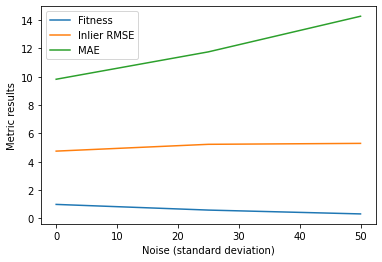

In [62]:
myObj_noisy.simulate_noise()

In [107]:
myObj = RegistrationObj(source_path, target_path, source_color_path, target_color_path, algorithm = "colored_icp",
                        pos_skiprows = [0,1,2], pos_usecols = [0,1,2], color_skiprows = [0,1,2], color_usecols = [0])


In [108]:
print(myObj)

--- Registration Object--- 
Algorithm used = colored_icp 
Preprocessing performed = False 
Registration performed = None


In [109]:
myObj

--- Registration Object--- 
Algorithm used = colored_icp 
Preprocessing performed = False 
Registration performed = None

In [29]:
myObj.create_pcd()


(PointCloud with 1784 points., PointCloud with 1689 points.)

In [30]:
myObj.target_pcd

PointCloud with 1689 points.

In [31]:
myObj.norm_source_color.shape

(1784, 1)

In [32]:
myObj.perform_registration()

:: RANSAC registration on point clouds.
   Since the  voxel size is 10.000,
   we use a liberal distance threshold 15.000.
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------


RegistrationResult with fitness=9.433857e-01, inlier_rmse=4.447616e+00, and correspondence_set size of 1683
Access transformation to get result.

In [141]:
myObj.transform_source()

PointCloud with 2363 points.

In [127]:
myObj.obtain_registration_metrics()

--- Registration results --- 
Fitness: 99.45%
Inlier RMSE: 4.57
MAE: 10.05
---------------------------------------
--- Correspondence map properties --- 
1220 (42.391%) unmapped targets.
562 (19.527%) targets that are mapped by multiple source points.
1096 (38.082%) targets that are uniquely mapped by a single source point.
All 2878 target points are accounted for.


In [128]:
print(myObj)

--- Registration Object--- 
Algorithm used = colored_icp 
Preprocessing performed = True 
Registration performed = True 
        
Fitness = 0.99 
Inlier RMSE = 4.57 
Scaled inlier RMSE = 4.59 
MAE = 10.05 
        
Registered color = None


In [129]:
myObj.map_source2target()

Using median averaging


(PointCloud with 2878 points.,
 array([[38.1764],
        [60.3887],
        [47.9133],
        ...,
        [18.553 ],
        [14.4744],
        [23.8   ]]))

In [131]:
myObj.registered_color

array([[38.1764],
       [60.3887],
       [47.9133],
       ...,
       [18.553 ],
       [14.4744],
       [23.8   ]])

In [133]:
myObj.norm_target_color

array([[13.8934267 ],
       [11.12891228],
       [ 8.17358078],
       ...,
       [ 1.21833929],
       [ 0.25214862],
       [ 2.46131542]])